## Conversational Analysis Toolkit

This notebook will build on the work in the orienting Networks notebook: we will primarily be using CornellNLP's [Conversational Analysis Toolkit](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit). From their page:

*This toolkit contains tools to extract conversational features and analyze social phenomena in conversations, using a single unified interface inspired by (and compatible with) scikit-learn. Several large conversational datasets are included together with scripts exemplifying the use of the toolkit on these datasets.*

We are going to demonstrate some of these, using the examples which they have on their GitHub page, and also encourage you all to check them out yourself!

### Imports

In [9]:
import lucem_illud_2020
import os

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile

from collections import defaultdict
from functools import partial
from multiprocessing import Pool

import convokit
from convokit import download
from convokit.prompt_types import PromptTypeWrapper
from convokit import PolitenessStrategies
from convokit import Corpus

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings('ignore')

Our first experiment will be in finding trends of coordination in conversations. We will use their built in Supreme Court dataset to do this!

In [2]:
corpus = convokit.Corpus(filename=convokit.download("supreme-corpus"))

## Coordination measures

The following section explores some of the metrics explored in the [Echoes of Power](https://www.cs.cornell.edu/~cristian/Echoes_of_power.html) paper.

We now run the coordination metrics on this corpus and print the ranked coordination.

In [3]:
# compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# get coordination scores
coord.transform(corpus)

In [4]:
# get set of all justices
justices = list(corpus.iter_users(lambda user: user.meta["is-justice"]))
# get set of all users
everyone = list(corpus.iter_users())

In [7]:
# compute coordination from each justice to everyone
print("Justices, ranked by how much they coordinate to others:")
justices_to_everyone = coord.score(corpus, justices, everyone)
for justice, score in sorted(justices_to_everyone.averages_by_user().items(),
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

Justices, ranked by how much they coordinate to others:
justice thomas 0.12485
justice breyer 0.04606
justice o'connor 0.04432
justice souter 0.04118
justice scalia 0.03885
justice kennedy 0.03414
justice stevens 0.03193
justice ginsburg 0.02437
chief justice rehnquist 0.01977
chief justice roberts 0.01922
justice alito 0.01045



In [8]:
# compute coordination from everyone to each justice
print("Justices, ranked by how much others coordinate to them:")
everyone_to_justices = coord.score(corpus, everyone, justices, focus="targets")
for justice, score in sorted(everyone_to_justices.averages_by_user().items(), 
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

Justices, ranked by how much others coordinate to them:
chief justice rehnquist 0.08959
chief justice roberts 0.0664
justice ginsburg 0.05971
justice o'connor 0.056
justice stevens 0.04988
justice alito 0.0446
justice kennedy 0.04276
justice souter 0.04045
justice scalia 0.03438
justice thomas 0.03393
justice breyer 0.02758



The [GitHub examples page](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/coordination/examples.ipynb) for Coordination provide further results from the Echoes of Power paper.

## Politeness Strategies

The following section demonstrates how to explore politness strategies and prompt types, as described in [ Conversations Gone Awry: Detecting Early Signs of Conversational Failure](http://www.cs.cornell.edu/~cristian/Conversations_gone_awry.html).

In [11]:
#  OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
DATA_DIR = '../data'
AWRY_ROOT_DIR = download('conversations-gone-awry-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# AWRY_ROOT_DIR = '<YOUR DIRECTORY>'

awry_corpus = Corpus(AWRY_ROOT_DIR)
awry_corpus.load_info('utterance', ['parsed'])

This is a larger dataset, so we only use 2018 occurences now.

In [12]:
# first, construct a table of conversations that meet the filter criteria (annotation_year = '2018')
kept_conversations = {c.id: c for c in awry_corpus.iter_conversations() if c.meta['annotation_year'] == "2018"}
# next, construct a filtered utterance table containing only the utterances in the filtered conversations
kept_utterances = {}
for convo_id in kept_conversations:
    for utterance in kept_conversations[convo_id].iter_utterances():
        kept_utterances[utterance.id] = utterance
# finally, we overwrite the `conversations` and `utterances` fields of the Corpus object to turn it into a filtered Corpus.
awry_corpus.conversations = kept_conversations
awry_corpus.utterances = kept_utterances
# make sure the size is what we expect
print(len(awry_corpus.conversations))
print(len(awry_corpus.utterances))

1168
6363


### Extracting prompt features

In this step, we will extract the first of the two types of pragmatic features seen in the paper: prompt types. We can learn prompt types and compute types for each utterance in the corpus using ConvoKit's PromptTypeWrapper class (which implements an end-to-end pipeline that extracts prompt types; see [this notebook](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/prompt-types/prompt-type-demo.ipynb) and [this notebook](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/prompt-types/prompt-type-wrapper-demo.ipynb) for examples of particular steps in that pipeline). Note that in keeping with proper machine learning practices, we need a different dataset to use for training the PromptTypeWrapper object. For this, we will use Convokit's Wikipedia talk corpus ("wiki-corpus"), which is comprised of Wikipedia talk page conversations different from those found in the Awry corpus.

In [13]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
FULL_ROOT_DIR = download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
# FULL_ROOT_DIR = '<YOUR DIRECTORY>'

full_corpus = Corpus(FULL_ROOT_DIR)
full_corpus.load_info('utterance', ['parsed'])

In [14]:
pt_model = PromptTypeWrapper(n_types=6, use_prompt_motifs=False, root_only=False,
                            questions_only=False, enforce_caps=False, min_support=20, min_df=100,
                            svd__n_components=50, max_dist=1., random_state=1000)
pt_model.fit(full_corpus)

10000/391294 utterances processed
20000/391294 utterances processed
30000/391294 utterances processed
40000/391294 utterances processed
50000/391294 utterances processed
60000/391294 utterances processed
70000/391294 utterances processed
80000/391294 utterances processed
90000/391294 utterances processed
100000/391294 utterances processed
110000/391294 utterances processed
120000/391294 utterances processed
130000/391294 utterances processed
140000/391294 utterances processed
150000/391294 utterances processed
160000/391294 utterances processed
170000/391294 utterances processed
180000/391294 utterances processed
190000/391294 utterances processed
200000/391294 utterances processed
210000/391294 utterances processed
220000/391294 utterances processed
230000/391294 utterances processed
240000/391294 utterances processed
250000/391294 utterances processed
260000/391294 utterances processed
270000/391294 utterances processed
280000/391294 utterances processed
290000/391294 utterances proc

Here are the six prompt types that our model has inferred -- i.e., prototypical features of the prompts and responses, as well as prototypical utterances for each type.
Note that due to updates in SpaCy's dependency parsing, as well as in our implementation of the prompt types methodology, the particular types returned don't fully align with what's in the paper (though we see that they recover similar prompt types, and down the line may result in better performance accuracies).

In [15]:
for i in range(6):
    print(i)
    pt_model.display_type(i,k=25, corpus=full_corpus)
    print('\n\n')

0
top prompt:
                    0         1         2         3         4         5  \
added_*      0.745644  1.041896  1.044112  0.915746  0.793351  0.805340   
found_*      0.751895  1.110785  1.080746  0.906195  0.878260  0.899150   
have_do      0.753992  1.141340  1.110224  0.875539  0.798163  1.001579   
also_*       0.755335  0.963896  0.961897  0.975669  0.859317  0.814378   
know_do      0.761443  1.155001  1.143333  0.860621  0.843105  1.002262   
link_*       0.767868  1.092466  1.005414  1.045515  0.999501  0.938837   
find_*       0.769916  1.128860  1.064833  0.974808  0.917275  0.891690   
be_should    0.771097  1.110656  0.984855  0.933710  0.869808  0.977408   
added_to     0.771135  1.043742  1.063298  0.944286  0.804712  0.844560   
find_ca      0.773848  1.200086  1.085779  1.011091  1.002955  0.943723   
where_*      0.776315  1.071769  0.962027  0.925209  0.990329  0.950330   
do>*         0.776742  1.095095  1.071784  0.918094  0.904697  0.984250   
also>*     

                         0         1         2         3         4         5  \
continue_*        1.151304  0.646004  0.946898  1.084261  1.086092  1.052146   
continue_if       1.134370  0.649720  0.936835  1.129623  1.162461  1.011157   
from_editing      1.103086  0.658219  0.928814  1.114490  1.142906  0.953969   
stop_*            1.136432  0.660538  0.893499  1.136701  1.186087  1.006843   
being_*           1.113748  0.662639  0.848397  0.989034  1.149655  1.006004   
disruptive_*      1.172893  0.663671  0.885561  1.131455  1.230537  1.048548   
making_*          1.104908  0.678408  0.880820  1.085583  1.134723  1.006527   
editing_*         1.008607  0.681476  0.964091  0.946316  0.952216  0.967205   
reverting_*       1.047783  0.682082  0.898783  1.027777  1.097422  0.949522   
stop_to           1.166984  0.684542  0.992609  1.091372  1.137320  1.058686   
without_*         1.015660  0.693359  0.820844  1.071656  1.108744  0.798541   
blocked_violate   1.117088  0.693952  0.

top prompt:
                       0         1         2         3         4         5  \
is_not          1.095490  0.887310  0.691028  1.206566  1.349564  0.973474   
stated_*        1.092537  0.820068  0.713869  1.139168  1.241661  1.027009   
clearly_*       1.122689  0.827619  0.736389  1.177101  1.320592  1.008721   
clear_*         1.107924  0.834251  0.741370  1.078990  1.244623  1.103486   
therefore_*     1.021693  0.913923  0.742395  1.186000  1.230123  0.911768   
said_*          1.109999  0.854325  0.744032  1.020157  1.252083  1.178831   
are_not         1.084398  0.890104  0.744711  1.185170  1.290041  1.017839   
relevant_*      1.003847  0.989838  0.745606  1.162675  1.234016  1.027901   
disagree_*      1.168034  0.897583  0.749432  1.154804  1.312209  1.084363   
is_in           0.906406  0.999533  0.750956  1.078177  1.171515  0.988554   
considered_*    1.036245  0.812779  0.751317  1.111646  1.237311  0.940790   
in>*            0.921729  0.900147  0.751632  1.0190

['as>* as_* explained_* explained_as explained_in in_*', 'reverted_* reverted_without without_*', 'does_* is_* is_say is_there is_while not_* say_* say_to support_* support_does support_is support_not there_* to_* while_*', 'like_* not_* said_* said_like so>* so>yes so_* sourced_* sourced_not sourced_said sourced_was was_* was_so was_yes yes_*', 'did_* no>* no_* not_* remove_* remove_did remove_no remove_not remove_without without_*', 'appropriately_* for_* leave_* leave_appropriately leave_for', '']




3
top prompt:
                  0         1         2         3         4         5  type_id
well_*     0.869018  1.037447  1.097557  0.644437  0.696542  1.095157      3.0
got_*      0.868713  1.078449  1.178155  0.651987  0.709004  1.100221      3.0
too_*      0.873654  1.111891  1.163379  0.658819  0.710150  1.121889      3.0
really_*   0.937846  0.964842  1.028344  0.663857  0.806418  1.131735      3.0
oh>*       0.884647  1.108864  1.178016  0.666343  0.780410  1.168683      3.0
th

                   0         1         2         3         4         5  \
'll_*       0.829504  1.089529  1.191825  0.743313  0.537392  1.050387   
've_*       0.839227  0.982956  1.139477  0.716148  0.559852  0.957947   
let_know    0.873020  1.055514  1.195226  0.885288  0.568045  0.946064   
let_*       0.900237  0.982351  1.159744  0.840959  0.570229  0.964175   
up_*        0.848435  1.016271  1.153817  0.674818  0.595524  1.016421   
get_*       0.881926  1.083018  1.207311  0.771206  0.599001  1.093815   
soon_*      0.928631  1.051014  1.188156  0.815184  0.601437  1.064579   
great_*     0.860229  1.179781  1.241356  0.830480  0.602625  1.140156   
try_'ll     0.818784  1.149333  1.208206  0.801255  0.602697  1.101453   
get_back    0.952348  1.028017  1.167118  0.815852  0.605440  1.096918   
working_on  0.902100  1.158199  1.250265  0.898167  0.608585  1.109242   
able_*      0.846367  1.115355  1.191415  0.862703  0.610012  1.046446   
working_*   0.899998  1.144041  1.2355

top prompt:
                          0         1         2         3         4         5  \
check_please       0.887739  1.003697  1.059574  1.067923  0.963643  0.555437   
restored_*         0.961581  0.884477  1.002420  1.066631  1.038220  0.566678   
tagged_*           0.922542  1.028905  1.081217  1.047580  0.978510  0.569728   
ask_have           0.896769  0.991893  1.031519  1.117379  0.996169  0.570399   
specified_*        0.912111  1.052185  1.055451  1.132344  1.023485  0.575033   
by_adding          0.917489  0.928586  1.021524  1.067536  0.994161  0.579310   
uploaded_have      0.945099  1.071692  1.092410  1.112573  1.039380  0.580434   
remove_please      1.000242  0.862857  0.957148  1.143626  1.110634  0.581222   
placed_was         0.954344  0.994487  0.991473  1.139008  1.102026  0.583313   
ask_at             0.914880  1.024118  1.064660  1.121473  1.011446  0.585099   
deleted_may        0.937451  1.072616  1.059098  1.142678  1.079830  0.586277   
remove_from     

We've given them the following names.

In [16]:
TYPE_NAMES = ['Prompt: Casual', 'Prompt: Moderation', 'Prompt: Coordination', 'Prompt: Contention',
             'Prompt: Editing', 'Prompt: Procedures']

In [17]:
awry_corpus = pt_model.transform(awry_corpus)

6363/6363 utterances processed
6363/6363 utterances processed
6363/6363 utterances processed


Now we want to gather the computed prompt types into a tabular format to use as features for an sklearn estimator. For our purposes, we want the distances from the centers of the KMeans clusters corresponding to each prompt type.

In [18]:
prompt_dist_df = pd.DataFrame(index=awry_corpus.vector_reprs['prompt_types__prompt_dists.6']['keys'],
                         data=awry_corpus.vector_reprs['prompt_types__prompt_dists.6']['vects'])
type_ids = np.argmin(prompt_dist_df.values, axis=1)
mask  = np.min(prompt_dist_df.values, axis=1) >= 1.
type_ids[mask] = 6

prompt_dist_df.columns = ['km_%d_dist' % c for c in prompt_dist_df.columns]

In [19]:
prompt_dist_df.head()


,km_0_dist,km_1_dist,km_2_dist,km_3_dist,km_4_dist,km_5_dist
146743638.12667.12652,0.848897,0.867569,0.851521,0.899780,0.953365,0.785587
146842219.12874.12874,0.777238,0.998354,0.879207,0.863979,0.957732,0.904714
146860774.13072.13072,0.796864,0.997266,1.001711,0.678024,0.803645,0.993687
143890867.11944.11926,1.010810,0.968777,0.799883,0.950007,1.234043,1.159978
143902946.11991.11991,0.920531,0.755597,0.951079,0.897044,0.856160,0.801869


In [20]:
prompt_type_assignments = np.zeros((len(prompt_dist_df), prompt_dist_df.shape[1]+1))
prompt_type_assignments[np.arange(len(type_ids)),type_ids] = 1
prompt_type_assignment_df = pd.DataFrame(columns=np.arange(prompt_dist_df.shape[1]+1), index=prompt_dist_df.index, 
                                        data=prompt_type_assignments)
prompt_type_assignment_df = prompt_type_assignment_df[prompt_type_assignment_df.columns[:-1]]

In [21]:
prompt_type_assignment_df.columns = TYPE_NAMES

In [22]:
prompt_type_assignment_df.head()

,Prompt: Casual,Prompt: Moderation,Prompt: Coordination,Prompt: Contention,Prompt: Editing,Prompt: Procedures
146743638.12667.12652,0.0,0.0,0.0,0.0,0.0,1.0
146842219.12874.12874,1.0,0.0,0.0,0.0,0.0,0.0
146860774.13072.13072,0.0,0.0,0.0,1.0,0.0,0.0
143890867.11944.11926,0.0,0.0,1.0,0.0,0.0,0.0
143902946.11991.11991,0.0,1.0,0.0,0.0,0.0,0.0


We can also get vector representations of the prompts!

In [26]:
awry_corpus.get_vect_repr("143902946.11991.11991", 'prompt_types__prompt_repr')

array([ 0.02194066,  0.02603126,  0.15196296,  0.09196109,  0.2374529 ,
        0.24243765, -0.05058274, -0.40252234,  0.18783706,  0.10802499,
        0.18622653,  0.09985349,  0.18804031,  0.25439551,  0.02281893,
        0.00309353, -0.07240287,  0.22384994, -0.04310281, -0.16004654,
        0.12180162,  0.07805198,  0.23561123, -0.01359641,  0.06849245,
       -0.08224021,  0.05948665, -0.20165399,  0.16727318,  0.01818681,
       -0.14461315,  0.22049171,  0.07041034, -0.05558084, -0.06358935,
        0.08575884, -0.00135684, -0.25354213, -0.11841355,  0.15244385,
        0.0428757 ,  0.15165744,  0.08217569,  0.08471339,  0.00632464,
       -0.00313882,  0.04902383, -0.12609311, -0.06542267])

The other notebooks linked earlier on have more work on prompts; these models were described here: [Asking Too Much? The Rhetorical Role of Questions in Political Discourse](http://www.cs.cornell.edu/~cristian/Asking_too_much.html)

We now move on to the politeness analysis.

### Extracting politeness features

Now we will extract the second type of pragmatic features described in the paper: politeness strategies. We can do this using convokit's PolitenessStrategies class. This class does not require any training, so we can just apply it directly to the corpus.

In [27]:
ps = PolitenessStrategies(verbose=1000)
awry_corpus = ps.transform(awry_corpus)

In [28]:
utterance_ids = awry_corpus.get_utterance_ids()
rows = []
for uid in utterance_ids:
    rows.append(awry_corpus.get_utterance(uid).meta["politeness_strategies"])
politeness_strategies = pd.DataFrame(rows, index=utterance_ids)

In [29]:
politeness_strategies.head(10)


,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,...,feature_politeness_==1st_person_start==,feature_politeness_==2nd_person==,feature_politeness_==2nd_person_start==,feature_politeness_==Indirect_(greeting)==,feature_politeness_==Direct_question==,feature_politeness_==Direct_start==,feature_politeness_==HASPOSITIVE==,feature_politeness_==HASNEGATIVE==,feature_politeness_==SUBJUNCTIVE==,feature_politeness_==INDICATIVE==
146743638.12652.12652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146743638.12667.12652,0,0,1,0,1,0,0,0,0,0,...,1,1,0,0,1,0,1,1,0,0
146842219.12874.12874,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
146860774.13072.13072,0,0,1,0,1,0,0,1,0,0,...,1,1,0,0,0,1,1,1,0,0
143890867.11926.11926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143890867.11944.11926,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
143902946.11991.11991,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
143945536.12065.12065,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
144052463.12169.12169,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
144065917.12226.12226,0,1,1,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


We now create paired data: the analyses performed in the paper, and the prediction task, considers pairs of conversations. The corpus downloaded from convokit already includes metadata about how conversations were paired for the paper, so we don't need to do any of the hard work here. Instead, we'll format the pair information into a table for use in prediction.

In [30]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.root)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)

# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})
# finally, we will augment the pairs dataframe with the IDs of the first and second comment for both
# the bad and good conversation. This will come in handy for constructing the feature matrix.
first_ids = []
second_ids = []
first_ids_bad = []
second_ids_bad = []
for row in pairs_df.itertuples():
    # "first two" is defined in terms of time of posting
    comments_sorted = comment_df[comment_df.conversation_id==row.conversation_id].sort_values(by="timestamp")
    first_ids.append(comments_sorted.iloc[0].name)
    second_ids.append(comments_sorted.iloc[1].name)
    comments_sorted_bad = comment_df[comment_df.conversation_id==row.bad_conversation_id].sort_values(by="timestamp")
    first_ids_bad.append(comments_sorted_bad.iloc[0].name)
    second_ids_bad.append(comments_sorted_bad.iloc[1].name)
pairs_df = pairs_df.assign(first_id=first_ids, second_id=second_ids, 
                           bad_first_id=first_ids_bad, bad_second_id=second_ids_bad)

We can compare how often the pragmatic devices we extracted occur in the initial exchanges of conversations that turn awry, vs. conversations that stay on track. We will compute log-odds ratios of each device, comparing the awry and on-track conversations; we will also compute significance values from binomal tests comparing the proportion of awry-turning conversations exhibiting a particular device to the proportion of on-track conversations.
Since we've already got the pragmatic features precomputed, and our dataset of pairs compiled, it remains to compute the effect sizes and statistical significances, and plot these values, producing a plot like Figure 2 from the paper.
Note: due to changes in SpaCy's dependency parsing that took place between the original time of publication and the updated release of this code, the extracted features may differ slightly from the ones used in the paper, so the resulting figure may differ slightly from the one in the paper.

In [31]:
def clean_feature_name(feat):
    new_feat = feat.replace('feature_politeness','').replace('==','').replace('_', ' ')
    split = new_feat.split()
    first, rest = split[0], ' '.join(split[1:]).lower()
    if first[0].isalpha():
        first = first.title()
    if 'Hashedge' in first:
        return 'Hedge (lexicon)'
    if 'Hedges' in first:
        return 'Hedge (dep. tree)'
    if 'greeting' in feat:
        return 'Greetings'
    cleaner_str = first + ' ' + rest
#     cleaner_str = cleaner_str.replace('2nd', '2$\mathregular{^{nd}}$').replace('1st', '1$\mathregular{^{st}}$')
    return cleaner_str

In [32]:
politeness_strategies_display = politeness_strategies[[col for col in politeness_strategies.columns 
                  if col not in ['feature_politeness_==HASNEGATIVE==', 'feature_politeness_==HASPOSITIVE==']]].copy()
politeness_strategies_display.columns = [clean_feature_name(col) for col in politeness_strategies_display.columns]

In [33]:
all_features = politeness_strategies_display.join(prompt_type_assignment_df)


In [34]:
tox_first_comment_features =pairs_df[['bad_first_id']].join(all_features, how='left', on='bad_first_id')[all_features.columns]
ntox_first_comment_features =pairs_df[['first_id']].join(all_features, how='left', on='first_id')[all_features.columns]

tox_second_comment_features =pairs_df[['bad_second_id']].join(all_features, how='left', on='bad_second_id')[all_features.columns]
ntox_second_comment_features =pairs_df[['second_id']].join(all_features, how='left', on='second_id')[all_features.columns]

In [35]:
def get_p_stars(x):
    if x < .001: return '***'
    elif x < .01: return '**'
    elif x < .05: return '*'
    else: return ''
def compare_tox(df_ntox, df_tox,  min_n=0):
    cols = df_ntox.columns
    num_feats_in_tox = df_tox[cols].sum().astype(int).rename('num_feat_tox')
    num_nfeats_in_tox = (1 - df_tox[cols]).sum().astype(int).rename('num_nfeat_tox')
    num_feats_in_ntox = df_ntox[cols].sum().astype(int).rename('num_feat_ntox')
    num_nfeats_in_ntox = (1 - df_ntox[cols]).sum().astype(int).rename('num_nfeat_ntox')
    prop_tox = df_tox[cols].mean().rename('prop_tox')
    ref_prop_ntox = df_ntox[cols].mean().rename('prop_ntox')
    n_tox = len(df_tox)
    df = pd.concat([
        num_feats_in_tox, 
        num_nfeats_in_tox,
        num_feats_in_ntox,
        num_nfeats_in_ntox,
        prop_tox,
        ref_prop_ntox,
    ], axis=1)
    df['num_total'] = df.num_feat_tox + df.num_feat_ntox
    df['log_odds'] = np.log(df.num_feat_tox) - np.log(df.num_nfeat_tox) \
        + np.log(df.num_nfeat_ntox) - np.log(df.num_feat_ntox)
    df['abs_log_odds'] = np.abs(df.log_odds)
    df['binom_p'] = df.apply(lambda x: stats.binom_test(x.num_feat_tox, n_tox, x.prop_ntox), axis=1)
    df = df[df.num_total >= min_n]
    df['p'] = df['binom_p'].apply(lambda x: '%.3f' % x)
    df['pstars'] = df['binom_p'].apply(get_p_stars)
    return df.sort_values('log_odds', ascending=False)

In [36]:
first_comparisons = compare_tox(ntox_first_comment_features, tox_first_comment_features)
second_comparisons = compare_tox(ntox_second_comment_features, tox_second_comment_features)

In [37]:
# we are now ready to plot these comparisons. the following (rather intimidating) helper function 
# produces a nicely-formatted plot:
def draw_figure(ax, first_cmp, second_cmp, title='', prompt_types=6, min_log_odds=.2, min_freq=50,xlim=.85):

    # selecting and sorting the features to plot, given minimum effect sizes and statistical significance
    frequent_feats = first_cmp[first_cmp.num_total >= min_freq].index.union(second_cmp[second_cmp.num_total >= min_freq].index)
    lrg_effect_feats = first_cmp[(first_cmp.abs_log_odds >= .2)
                                & (first_cmp.binom_p < .05)].index.union(second_cmp[(second_cmp.abs_log_odds >= .2)
                                                                                  & (second_cmp.binom_p < .05)].index)
    feats_to_include = frequent_feats.intersection(lrg_effect_feats)
    feat_order = sorted(feats_to_include, key=lambda x: first_cmp.loc[x].log_odds, reverse=True)

    # parameters determining the look of the figure
    colors = ['darkorchid', 'seagreen']
    shapes = ['d', 's']    
    eps = .02
    star_eps = .035
    xlim = xlim
    min_log = .2
    gap_prop = 2
    label_size = 14
    title_size=18
    radius = 144
    features = feat_order
    ax.invert_yaxis()
    ax.plot([0,0], [0, len(features)/gap_prop], color='black')
    
    # for each figure we plot the point according to effect size in the first and second comment, 
    # and add axis labels denoting statistical significance
    yticks = []
    yticklabels = []
    for f_idx, feat in enumerate(features):
        curr_y = (f_idx + .5)/gap_prop
        yticks.append(curr_y)
        try:
            
            first_p = first_cmp.loc[feat].binom_p
            second_p = second_cmp.loc[feat].binom_p            
            if first_cmp.loc[feat].abs_log_odds < min_log:
                first_face = "white"
            elif first_p >= 0.05:
                first_face = 'white'
            else:
                first_face = colors[0]
            if second_cmp.loc[feat].abs_log_odds < min_log:
                second_face = "white"
            elif second_p >= 0.05:
                second_face = 'white'
            else:
                second_face = colors[1]
            ax.plot([-1 * xlim, xlim], [curr_y, curr_y], '--', color='grey', zorder=0, linewidth=.5)
            
            ax.scatter([first_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[0], marker=shapes[0],
                        zorder=20, facecolors=first_face)
            ax.scatter([second_cmp.loc[feat].log_odds], [curr_y + eps], s=radius, edgecolor=colors[1], marker=shapes[1], 
                       zorder=10, facecolors=second_face)
            
            first_pstr_len = len(get_p_stars(first_p))
            second_pstr_len = len(get_p_stars(second_p))
            p_str = np.array([' '] * 8)
            if first_pstr_len > 0:
                p_str[:first_pstr_len] = '*'
            if second_pstr_len > 0:
                p_str[-second_pstr_len:] = '⁺'
            
            feat_str = feat + '\n' + ''.join(p_str)
            yticklabels.append(feat_str)
        except Exception as e:
            yticklabels.append('')
    
    # add the axis labels
    ax.set_xlabel('log-odds ratio', fontsize=14, family='serif')
    ax.set_xticks([-xlim-.05, -.5, 0, .5, xlim])
    ax.set_xticklabels(['on-track', -.5, 0, .5, 'awry'], fontsize=14, family='serif')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=16, family='serif')
    ax.tick_params(axis='both',  which='both', bottom='off',  top='off',left='off')
    if title != '':
        ax.text(0, (len(features) + 2.25)/ gap_prop, title, fontsize=title_size, family='serif',horizontalalignment='center',)
    return feat_order

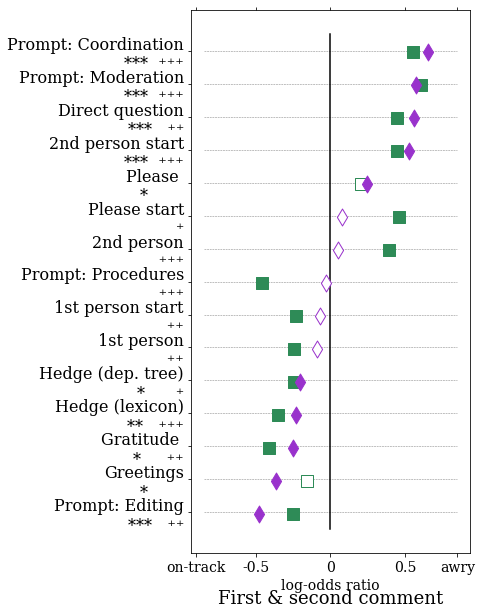

In [38]:
f, ax = plt.subplots(1,1, figsize=(5,10))
_ = draw_figure(ax, first_comparisons, second_comparisons, 'First & second comment')

#### Constructing Feature Matrix

To run the prediction task, we can construct a table of pragmatic features for each pair, to use in prediction. This table will consist of the prompt types and politeness strategies for the first and second comment of each conversation.

In [39]:
def features_for_convo(convo_id, first_comment_id, second_comment_id):

    # get prompt type features
    try:
        first_prompts = prompt_dist_df.loc[first_comment_id]
    except:
        first_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=prompt_dist_df.columns)
    try:
        second_prompts = prompt_dist_df.loc[second_comment_id].rename({c: c + "_second" for c in prompt_dist_df.columns})
    except:
        second_prompts = pd.Series(data=np.ones(len(prompt_dist_df.columns)), index=[c + "_second" for c in prompt_dist_df.columns])
    prompts = first_prompts.append(second_prompts)
    # get politeness strategies features
    first_politeness = politeness_strategies.loc[first_comment_id]
    second_politeness = politeness_strategies.loc[second_comment_id].rename({c: c + "_second" for c in politeness_strategies.columns})
    politeness = first_politeness.append(second_politeness)
    return politeness.append(prompts)

In [40]:
convo_ids = np.concatenate((pairs_df.conversation_id.values, pairs_df.bad_conversation_id.values))
feats = [features_for_convo(row.conversation_id, row.first_id, row.second_id) for row in pairs_df.itertuples()] + \
        [features_for_convo(row.bad_conversation_id, row.bad_first_id, row.bad_second_id) for row in pairs_df.itertuples()]
feature_table = pd.DataFrame(data=np.vstack([f.values for f in feats]), columns=feats[0].index, index=convo_ids)

In [41]:
# in the paper, we dropped the sentiment lexicon based features (HASPOSITIVE and HASNEGATIVE), opting
# to instead use them as a baseline. We do this here as well to be consistent with the paper.
feature_table = feature_table.drop(columns=["feature_politeness_==HASPOSITIVE==",
                                            "feature_politeness_==HASNEGATIVE==",
                                            "feature_politeness_==HASPOSITIVE==_second",
                                            "feature_politeness_==HASNEGATIVE==_second"])

In [42]:
feature_table.head(5)


,feature_politeness_==Please==,feature_politeness_==Please_start==,feature_politeness_==HASHEDGE==,feature_politeness_==Indirect_(btw)==,feature_politeness_==Hedges==,feature_politeness_==Factuality==,feature_politeness_==Deference==,feature_politeness_==Gratitude==,feature_politeness_==Apologizing==,feature_politeness_==1st_person_pl.==,...,km_2_dist,km_3_dist,km_4_dist,km_5_dist,km_0_dist_second,km_1_dist_second,km_2_dist_second,km_3_dist_second,km_4_dist_second,km_5_dist_second
292012508.4356.4356,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.907211,1.144273,1.123359,0.707644,0.827025,0.997480,0.897530,0.782002,0.948048,1.052538
139339329.5788.5791,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.025519,0.739912,0.726995,0.993443,0.859068,0.846208,0.857211,0.831555,0.876687,0.901602
74631077.12510.12510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.070468,0.710041,0.761650,1.028084,1.033315,0.820943,1.022168,0.954869,0.899261,0.962413
381107546.10031.10031,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.038875,0.860605,0.736118,0.980222,0.826946,1.008223,1.117242,0.688201,0.626586,1.010449
82495354.7169.7169,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.882674,0.893166,0.879458,0.779963,0.820719,0.962931,0.991332,1.020880,0.888611,0.706526


We set up some prediction helper functions!

In [44]:
def mode(seq):
    vals, counts = np.unique(seq, return_counts=True)
    return vals[np.argmax(counts)]

def run_pred_single(inputs, X, y):
    f_idx, (train_idx, test_idx) = inputs
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    base_clf = Pipeline([("scaler", StandardScaler()), ("featselect", SelectPercentile(f_classif, 10)), ("logreg", LogisticRegression(solver='liblinear'))])
    clf = GridSearchCV(base_clf, {"logreg__C": [10**i for i in range(-4,4)], "featselect__percentile": list(range(10, 110, 10))}, cv=3)

    clf.fit(X_train, y_train)
    
    y_scores = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    
    feature_weights = clf.best_estimator_.named_steps["logreg"].coef_.flatten()
    feature_mask = clf.best_estimator_.named_steps["featselect"].get_support()
    
    hyperparams = clf.best_params_
    
    return (y_pred, y_scores, feature_weights, hyperparams, feature_mask)

def run_pred(X, y, fnames, groups):
    feature_weights = {}
    scores = np.asarray([np.nan for i in range(len(y))])
    y_pred = np.zeros(len(y))
    hyperparameters = defaultdict(list)
    splits = list(enumerate(LeaveOneGroupOut().split(X, y, groups)))
    accs = []
        
    with Pool(os.cpu_count()) as p:
        prediction_results = p.map(partial(run_pred_single, X=X, y=y), splits)
        
    fselect_pvals_all = []
    for i in range(len(splits)):
        f_idx, (train_idx, test_idx) = splits[i]
        y_pred_i, y_scores_i, weights_i, hyperparams_i, mask_i = prediction_results[i]
        y_pred[test_idx] = y_pred_i
        scores[test_idx] = y_scores_i
        feature_weights[f_idx] = np.asarray([np.nan for _ in range(len(fnames))])
        feature_weights[f_idx][mask_i] = weights_i
        for param in hyperparams_i:
            hyperparameters[param].append(hyperparams_i[param])   
    
    acc = np.mean(y_pred == y)
    pvalue = stats.binom_test(sum(y_pred == y), n=len(y), alternative="greater")
                
    coef_df = pd.DataFrame(feature_weights, index=fnames)
    coef_df['mean_coef'] = coef_df.apply(np.nanmean, axis=1)
    coef_df['std_coef'] = coef_df.apply(np.nanstd, axis=1)
    return acc, coef_df[['mean_coef', 'std_coef']], scores, pd.DataFrame(hyperparameters), pvalue

def get_labeled_pairs(pairs_df):
    paired_labels = []
    c0s = []
    c1s = []
    page_ids = []
    for i, row in enumerate(pairs_df.itertuples()):
        if i % 2 == 0:
            c0s.append(row.conversation_id)
            c1s.append(row.bad_conversation_id)
        else:
            c0s.append(row.bad_conversation_id)
            c1s.append(row.conversation_id)
        paired_labels.append(i%2)
        page_ids.append(row.page_id)
    return pd.DataFrame({"c0": c0s, "c1": c1s,"first_convo_toxic": paired_labels, "page_id": page_ids})

def get_feature_subset(labeled_pairs_df, feature_list):
    prompt_type_names = ["km_%d_dist" % i for i in range(6)] + ["km_%d_dist_second" % i for i in range(6)]
    politeness_names = [f for f in feature_table.columns if f not in prompt_type_names]
    
    features_to_use = []
    if "prompt_types" in feature_list:
        features_to_use += prompt_type_names
    if "politeness_strategies" in feature_list:
        features_to_use += politeness_names
        
    feature_subset = feature_table[features_to_use]
    
    c0_feats = feature_subset.loc[labeled_pairs_df.c0].values
    c1_feats = feature_subset.loc[labeled_pairs_df.c1].values
    
    return c0_feats, c1_feats, features_to_use

def run_pipeline(feature_set):
    print("Running prediction task for feature set", "+".join(feature_set))
    print("Generating labels...")
    labeled_pairs_df = get_labeled_pairs(pairs_df)
    print("Computing paired features...")
    X_c0, X_c1, feature_names = get_feature_subset(labeled_pairs_df, feature_set)
    X = X_c1 - X_c0
    print("Using", X.shape[1], "features")
    y = labeled_pairs_df.first_convo_toxic.values
    print("Running leave-one-page-out prediction...")
    accuracy, coefs, scores, hyperparams, pvalue = run_pred(X, y, feature_names, labeled_pairs_df.page_id)
    print("Accuracy:", accuracy)
    print("p-value: %.4e" % pvalue)
    print("C (mode):", mode(hyperparams.logreg__C))
    print("Percent of features (mode):", mode(hyperparams.featselect__percentile))
    print("Coefficents:")
    print(coefs.sort_values(by="mean_coef"))
    return accuracy

In [45]:
feature_combos = [["politeness_strategies"], ["prompt_types"], ["politeness_strategies", "prompt_types"]]
combo_names = []
accs = []
for combo in feature_combos:
    combo_names.append("+".join(combo).replace("_", " "))
    accuracy = run_pipeline(combo)
    accs.append(accuracy)
results_df = pd.DataFrame({"Accuracy": accs}, index=combo_names)
results_df.index.name = "Feature set"

Running prediction task for feature set politeness_strategies
Generating labels...
Computing paired features...
Using 38 features
Running leave-one-page-out prediction...
Accuracy: 0.5976027397260274
p-value: 1.3654e-06
C (mode): 0.1
Percent of features (mode): 60
Coefficents:
                                                   mean_coef  std_coef
feature_politeness_==2nd_person==_second           -0.299293  0.040108
feature_politeness_==2nd_person_start==            -0.233884  0.030364
feature_politeness_==Direct_question==             -0.179524  0.021340
feature_politeness_==2nd_person_start==_second     -0.174717  0.021307
feature_politeness_==Direct_question==_second      -0.133476  0.016420
feature_politeness_==Please_start==_second         -0.088859  0.010623
feature_politeness_==Indirect_(btw)==              -0.087011  0.018463
feature_politeness_==Factuality==                  -0.074998  0.010055
feature_politeness_==Please==                      -0.074088  0.009127
feature_poli

In [46]:
results_df


,Accuracy
Feature set,
politeness strategies,0.597603
prompt types,0.611301
politeness strategies+prompt types,0.642123


We've more or less recreated the results from the paper!

## Hypergraph Conversation Representation

The following are examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper [Characterizing Online Public Discussions through Patterns of Participant Interactions ](http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

We use reddit threads to model the conversations.

In [47]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus-small"))

In [48]:
corpus.meta


{'subreddit': 'reddit-corpus-small',
 'num_posts': 8286,
 'num_comments': 288846,
 'num_user': 119889}

In [77]:
corpus.print_summary_stats()


Number of Users: 119889
Number of Utterances: 297132
Number of Conversations: 8286


In [78]:
top_level_utterance_ids = [utt.id for utt in corpus.iter_utterances() if utt.id == utt.meta['top_level_comment']]

In [79]:
len(top_level_utterance_ids)


10000

In [80]:
next(corpus.iter_conversations()).meta


{'title': '/r/singapore random discussion and small questions thread for September 02, 2018',
 'num_comments': 745,
 'domain': 'self.singapore',
 'timestamp': 1535839576,
 'subreddit': 'singapore',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'stickied': False,
 'author_flair_text': '',
 'hyperconvo': {'max[indegree over c->c responses]': 4,
  'argmax[indegree over c->c responses]': 1,
  'norm.max[indegree over c->c responses]': 0.4444444444444444,
  '2nd-largest[indegree over c->c responses]': 2,
  '2nd-argmax[indegree over c->c responses]': 5,
  'norm.2nd-largest[indegree over c->c responses]': 0.2222222222222222,
  'mean[indegree over c->c responses]': 0.9,
  'mean-nonzero[indegree over c->c responses]': 1.8,
  'prop-nonzero[indegree over c->c responses]': 0.5,
  'prop-multiple[indegree over c->c responses]': 0.4,
  'entropy[indegree over c->c responses]': 1.4270610433807247,
  '2nd-largest / max[indegree over c->c responses]': 0.5,
  'max[outdegree over C->c re

In [ ]:
threads_corpus = corpus.reindex_conversations(new_convo_roots=top_level_utterance_ids, 
                                              preserve_convo_meta=True,
                                              preserve_corpus_meta=False)

In [ ]:
corpus.get_utterance('9bzh9g')


In [ ]:
corpus.print_summary_stats()


In [ ]:
threads_corpus.print_summary_stats()


We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, some threads have a very linear structure, while others are flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [ ]:
demo_threads = ['e57u6ft', 'e56rtrx']


In [ ]:
threads_corpus.get_conversation('e57u6ft').print_conversation_structure()


In [ ]:
threads_corpus.get_conversation('e56rtrx').print_conversation_structure()


In [ ]:
threads_corpus.get_conversation('e56rtrx').print_conversation_structure(lambda utt: utt.text)



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.
Typically, to extract hypergraph features, we would simply:

In [ ]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10)
hc.fit_transform(threads_corpus)

In [ ]:
convo1 = next(threads_corpus.iter_conversations())
print(convo1.id)
convo1.meta['hyperconvo']

Hyperconvo's fit_transform() method generates features data for each thread (either starting with the post or top-level comment) and stores it in the corresponding Conversation's (which is indexed by post id) metadata. We collect the thread features from each Conversation to do some aggregated analysis.

In [ ]:
threads_feats = dict()

for convo in threads_corpus.iter_conversations():
    threads_feats[convo.id] = convo.meta['hyperconvo']

In [ ]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [ ]:
feat_names = list(next(iter(threads_feats.values())).keys())


In [ ]:
feat_names[:10]


In [ ]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:


In [ ]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)


Here are some examples of features computed over the three example threads from before:


In [ ]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution.
As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [ ]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()


Features derived from the distribution of hypernode to hypernode outdegrees in the middle of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?").

In [ ]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features counts of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [ ]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space.

In [ ]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
feat_mtx = SimpleImputer(missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [ ]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \

In [ ]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:


In [ ]:
U_df.loc[demo_threads].T


As well as embeddings of features:


In [ ]:
V_df.loc[C_C_indegree_feats]


In [ ]:
convo1.meta


As in the paper, for further interpretability we can consider embeddings of communities (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.


In [ ]:
subreddits = [convo.meta['original_convo_meta']['subreddit'] for convo in threads_corpus.iter_conversations()]

In [ ]:
len(subreddits)


In [ ]:
U_df['subreddit'] = subreddits


In [ ]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [ ]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:


In [ ]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()


For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).
There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.
Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:


In [ ]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [ ]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [ ]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])


We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [ ]:
from IPython.display import display


In [ ]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [ ]:
top_threads = display_dimension(0, n=10)


## Linguistic Diversity in Conversations

We will now explore the part of the toolkit dealing with giving characteristics to different actors in a conversation. This will likely most fit in with the datasets we've seen in our previous notebook. It attempts to carry out the methods in the [Finding Your Voice: The Linguistic Development of Mental Health Counselors](http://www.cs.cornell.edu/~cristian/Finding_your_voice__linguistic_development.html).

Since we cannot publicly release the dataset of counseling conversations used in that paper, we will use the ChangeMyView subreddit as a test case---as such, this notebook is mostly to demonstrate how the functionality works, rather than to suggest any substantive scientific claims about longitudinal behavior change.

In [ ]:
# OPTION 1: DOWNLOAD CORPUS
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
ROOT_DIR = convokit.download('subreddit-changemyview', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE CORPUS IS LOCATED
# ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(ROOT_DIR)

In [ ]:
corpus.print_summary_stats()


To start, we will set up a data structure mapping each user to their conversations, and each utterance they contributed in the conversation.
To do this we call the ```organize_user_convo_history function```, which annotates each User in a corpus with a dict of conversations --> the user's utterances in that conversation, and the timestamp of their first utterance (i.e., when they "entered" the conversation).
Note that we can specify what counts as participating in a conversation. Here, we omit posts and focus only on comments (such that a user doesn't count as participating if they only submitted the root post)

In [ ]:
USER_BLACKLIST = ['[deleted]', 'DeltaBot','AutoModerator']
def utterance_is_valid(utterance):
    return (utterance.id != utterance.root) and (utterance.user.name not in USER_BLACKLIST)

In [ ]:
corpus.organize_user_convo_history(utterance_filter=utterance_is_valid)


In [ ]:
corpus.get_user('ThatBelligerentSloth').meta['n_convos']


In [ ]:
corpus.get_user('ThatBelligerentSloth').meta['start_time']



For each user, we maintain a dictionary in their meta information of conversation ID to a record fo the user's behavior in that conversation:

In [ ]:
corpus.get_user('ThatBelligerentSloth').meta['conversations']['2wm22t']


to speed up this demo, we will only take the top 100 most active users.
To help with this, the get_attribute_table function call gives us a Pandas dataframe where indices correspond to usernames, and which contains the number of comments each user participated in.

In [ ]:
user_activities = corpus.get_attribute_table('user',['n_convos'])


In [ ]:
user_activities.sort_values('n_convos', ascending=False).head(10)


In [ ]:
top_users = user_activities.sort_values('n_convos', ascending=False).head(100).index


In [ ]:
subset_utts = []
for user in top_users:
    subset_utts += list(corpus.get_user(user).iter_utterances())
subset_corpus = Corpus(utterances=subset_utts)

In [ ]:
subset_corpus.print_summary_stats()


Finally, to finish setting things up, we will tokenize the utterances using the TextParser transformer (this is somewhat slow; setting the mode to 'tokenize' means we avoid having to perform expensive dependency-parse computations, which we do not need for the present analysis).

In [ ]:
from convokit.text_processing import TextProcessor, TextParser


In [ ]:
tokenizer = TextParser(mode='tokenize', output_field='tokens', verbosity=1000)
subset_corpus = tokenizer.transform(subset_corpus)

Here's what the tokenized output looks like for one utterance (for a more in-depth explanation, check out the TextParser documentation.

In [ ]:
subset_corpus.get_utterance('cos7k4p').get_info('tokens')


### Analysis

The goal of this analysis is to examine how a user's conversational behavior looks like within a single conversation, and then how it evolves over the conversations they take. To demonstrate what this looks like we'll start with a simple attribute, wordcount. First, we count the words in each utterance using the TextProcessor transformer. Note this computes per utterance statistics.

In [ ]:
wordcounter = TextProcessor(input_field='tokens', output_field='wordcount', 
                           proc_fn=lambda sents: sum(len(sent['toks']) for sent in sents), verbosity=25000)
subset_corpus = wordcounter.transform(subset_corpus)

In [ ]:
subset_corpus.get_utterance('cos7k4p').get_info('wordcount')


In [ ]:
subset_corpus.get_utterance('cos8ffz').get_info('wordcount')


Next, we aggregate per-utterance statistics over all the utterances a particular user contributed in a conversation. That is, we will turn wordcount into a user,convo-level attribute.
We call the ```UserConvoAttrs``` transformer to do this. Here, agg_fn=np.mean means that the user,convo-le

In [ ]:
import numpy as np


In [ ]:
uc_wordcount = convokit.user_convo_helpers.user_convo_attrs.UserConvoAttrs('wordcount', agg_fn=np.mean)
subset_corpus = uc_wordcount.transform(subset_corpus)

This transformer annotates each conversation in each User object with a (mean) wordcount:


In [ ]:
subset_corpus.get_user('ThatBelligerentSloth').meta['conversations']['2wm22t']


We will now use this aggregate statistic to analyze how users change behavior over time. The particular question here is whether or not users systematically increase or decrease in wordcount, and in the number of utterances contributed to each conversation.
To facilitate further analyses, we'll load all the user,convo information pertaining to the attributes we want into a dataframe. We'll use the get_full_attribute_table function to do this (the particular call tells the function to load a table with wordcount and # of utterances at the user,conversation level, and # of conversations i.e., how active the user was, at the user level).

In [ ]:
user_convo_len_df = subset_corpus.get_full_attribute_table(user_convo_attrs=['wordcount','n_utterances'],
                                             user_attrs=['n_convos'])


In [ ]:
user_convo_len_df.head()


We perform our longitudinal analyses at the level of life-stages: i.e., contiguous blocks of conversations. Here, we compare between the first two life-stages of 10 conversations: how the user behaves in their first 10, versus their 10th to 20th conversations. We say that users systematically increase (or decrease) in an attribute if for a significant majority of users the value of this attribute at one life-stage increases to the next.
To this end, we need to aggregate attributes over a life-stage, e.g., mean wordcount. To perform this aggregation we'll use the get_lifestage_attributes function, specifying lifestages of 10 conversations each.

In [ ]:
def get_lifestage_attributes(attr_df, attr, lifestage_size, agg_fn=np.mean):
    aggs = attr_df.groupby(['user', attr_df.convo_idx // lifestage_size])\
        [attr].agg(agg_fn)
    aggs = aggs.reset_index().pivot(index='user', columns='convo_idx',
                                   values=attr)
    return aggs


We focus on the first 20 conversations (i.e., 2 life-stages). We also ignore all users with less than 20 conversations---so we are not biased by survivorship.


In [ ]:
subset = user_convo_len_df[(user_convo_len_df.n_convos__user >= 20)
                          & (user_convo_len_df.convo_idx < 20)]


In [ ]:
stage_wc_df = get_lifestage_attributes(subset, 'wordcount', 10)


In [ ]:
stage_wc_df.head()


In [ ]:
stage_wc_df.mean()


In [ ]:
from scipy import stats


In [ ]:
def print_lifestage_comparisons(stage_df):
    for i in range(stage_df.columns.max()):
        
        mask = stage_df[i+1].notnull() & stage_df[i].notnull()
        c1 = stage_df[i+1][mask]
        c0 = stage_df[i][mask]
        
        print('stages %d vs %d (%d users)' % (i + 1, i, sum(mask)))
        n_more = sum(c1 > c0)
        n = sum(c1 != c0)
        print('\tprop more: %.3f, binom_p=%.2f' % (n_more/n, stats.binom_test(n_more,n)))

In [ ]:
print_lifestage_comparisons(stage_wc_df)


In [ ]:
stage_convo_len_df = get_lifestage_attributes(subset, 'n_utterances', 10)


In [ ]:
stage_convo_len_df.mean()


Just looking at the means, it looks like there's a slight decrease in wordcount across the population from the first to the second lifestage. To check significance, we can compute that % of users who experience this decrease, and see if it's significant per a binomial test against a null proportion of 50% of users (ie., people randomly increase or decrease)
We see that this is (almost) significant ... maybe more data would help!


In [ ]:
print_lifestage_comparisons(stage_convo_len_df)


Finally, we'll compute some attributes related to linguistic diversity described in the following paper : http://www.cs.cornell.edu/~cristian/Finding_your_voice__linguistic_development.html
In short, for each life-stage, we compare the words used by one user in one conversation to the words they use in their other conversations, or the words that others use. As such, this is a user,convo-level attribute. Given our small sample here (and the fact that CMV and crisis counseling conversations are very different), we're not going for any scientific claims, but use the following function calls to demostrate how the pipeline would work.
These attributes are all computed through the UserConvoDiversityWrapper transformer, which computes three attributes:

div__self: within-diversity in the paper, comparing language use across a user's own conversations

div__other: between-diversity in the paper, comparing language use across different users

div__adj: relative diversity: between - within. (intuitively, is the diversity coming from users being different from 
others, beyond being diverse in their own right?)


Under the surface, UserConvoDiversityWrapper calls a more general UserConvoDiversity transformer, which allows for computation of how divergent a conversation is from any arbitrary reference set of conversations, beyond life-stages (see the documentation for details).

In [ ]:
from convokit import UserConvoDiversityWrapper


In [ ]:
ucd = convokit.UserConvoDiversityWrapper(lifestage_size=10, max_exp=20,
                sample_size=300, min_n_utterances=1, n_iters=50, cohort_delta=60*60*24*30*2, verbosity=100)

(this takes a while to run, especially with more users involved)


In [ ]:
subset_corpus = ucd.transform(subset_corpus)


In [ ]:
div_df = subset_corpus.get_full_attribute_table(['div__self','div__other','div__adj', 'tokens', 'n_utterances'], ['n_convos'])

note that one present limitation of this methodology is that it requires a user's activity in a conversation---and in their other conversations---to be substantive enough. if a user doesn't meet the minimum wordcount per conversation, then the function returns np.nan for that particular user,conversation. Filtering out these null values:

In [ ]:
div_df = div_df[div_df.div__self.notnull() | div_df.div__other.notnull()]


In [ ]:
div_df.shape


as with the wordcount example, we can make cross-lifestage comparisons. here we unfortunately see no significant population-wide change in either direction. This might be worth exploring with more users, though note that interpreting this result for CMV versus for counseling conversations where users are randomly assigned might be different.


In [ ]:
for attr in ['div__self','div__other','div__adj']:
    print(attr)
    stage_df = get_lifestage_attributes(div_df, attr, 10)
    print_lifestage_comparisons(stage_df)
    print('\n\n===')

## Final Notes

This notebook was put toegther from a combination of notebooks and code snippets from the GitHub documentation. We recommend checking out the GitHub and documentation to see what other functionality will be helpful for your research projects.

#### Forecasting conversations

These two Google Colab notebooks ([notebook 1](https://colab.research.google.com/drive/1SH4iMEHdoH4IovN-b9QOSK4kG4DhAwmb), [notebook 2](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH)) walk you through using convokits neural models to see how conversations turn (become more personal, angry, etc).

#### Datasets

convokit also includes a variety of [datasets](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit#datasets) which would be very useful. 